## Fine-tuning to follow instructions

In order to follow instructions properly, the model pre-trained on text completion requires another stage of supervised instruction fine-tuning. Here, we use a dataset of instructions and it's desired answers to make the model better respond to such inputs. One of the most important steps here is the creation of the dataset.

### Preparing the dataset

We start by downloading an instruction dataset with 1100 instruction-response pairs.

In [1]:
import json
import os
import urllib


def download_and_load_file(file_path: str, url: str):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w") as f:
            f.write(text_data)
    else:
        with open(file_path, "r") as f:
            text_data = f.read()
    with open(file_path, "r") as f:
        data = json.load(f)
    return data

file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries in the dataset:", len(data))

print("Example entry:\n", data[50])
print("Another example:\n", data[999])

Number of entries in the dataset: 1100
Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}
Another example:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


From the examples above we can see that each sample is a dictionary with keys `instruction`, `input` and `output`. Field `input` might be empty for some cases.

There are different ways of formatting those inputs for instruction fine-tuning. We will use Alpaca-style formatting throughout this notebook. It encodes the inputs and outputs as follows:

```text

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instructions:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion'.
```

We will define a function called `format_input` to convert the json samples into the required format.

In [2]:
def format_input(entry: dict[str, str]) -> str:
    instruction_text = (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request."
        f"\n\n### Instructions:\n{entry['instruction']}"
    )

    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    )

    return instruction_text + input_text

model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instructions:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


For the example without an input value, this part will be skipped.

In [3]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"
print(model_input + desired_response)




Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instructions:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


We now divide the dataset into train, validation and test set.

In [4]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


### Organizing data into training batches

As the next step, we need to make sure that the model receives the formatted data in the required batches. We will use a PyTorch dataloader for this as in the previous chapters, but write a custom collate function for it which will define the steps to create the required input.

As a first step we will define a `InstructionDataset` class which applies the format_input and *pretokenizes* the inputs.

In [5]:
from typing import Any

import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data: list[dict[str, str]], tokenizer: Any):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index: int) -> list[int]:
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

Similar to classification fine-tuning, we need to use a special padding token to indicate the end of a sample text. We will again use `<|endoftext|>` for this purpose and append the corresponding token ID to the encoded text directly rather than append the string to the text. The token ID for this padding string is `50256`.

We implement the padding process in the custom collate function.

In [6]:
def custom_collate_draft_1(
    batch: list[list[int]], pad_token_id: int = 50256, device="cpu"
) -> torch.Tensor:
    batch_max_length = max(len(item) + 1 for item in batch)
    inputs_lst = []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

The collate function can be integrated into a `DataLoader` as well as serve as a standalone function. To test it, we will use it as a separate function.

In [7]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = [
    inputs_1,
    inputs_2,
    inputs_3,
]

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


We can see that our collate function correctly pads the various input sample to the longest sample in the batch.

We will now update the collate function to also generate the target token IDs.

In [8]:
def custom_collate_draft_2(
    batch: list[list[int]], pad_token_id: int = 50256, device="cpu"
) -> tuple[torch.Tensor, torch.Tensor]:
    batch_max_length = max(len(item) + 1 for item in batch)
    inputs_lst, targets_lst = [], []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)
        targets = torch.tensor(padded[1:])
        targets_lst.append(targets)
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor


inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


As a next step, we will replace the padding tokens after the first one with the special value `-100`. This will exclude those tokens from the loss calculation.

In [9]:
def custom_collate_fn(
    batch: list[list[int]], 
    pad_token_id: int = 50256, 
    ignore_index: int = -100, 
    allowed_max_length: int | None = None, 
    device: torch.device = torch.device("cpu")
) -> tuple[torch.Tensor, torch.Tensor]:
    batch_max_length = max(len(item) + 1 for item in batch)
    if allowed_max_length is not None:
        batch_max_length = min(batch_max_length, allowed_max_length)
    inputs_lst, targets_lst = [], []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]
            
        inputs_lst.append(inputs)
        targets_lst.append(targets)
        
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [10]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


The target tokens are now changed such that all padding tokens after the first one are exchanged to the ignore_token.

We can see the impact of this on a loss function in the example below.

In [ ]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5]]
)
targets_1 = torch.tensor([0, 1]) 
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

# Adding another token ID
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]
)
targets_2 = torch.tensor([0, 1, 1])
loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

# Replacing the extra token ID with -100
logits_3 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]
)
targets_3 = torch.tensor([0, 1, -100])
loss_3 = torch.nn.functional.cross_entropy(logits_3, targets_3)
print(loss_3)

print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
tensor(0.7936)
tensor(1.1269)
loss_1 == loss_3: tensor(True)


The reason the loss function ignores values `-100` is that function `cross_entropy` by default has argument `ignore_index=-100`.

Often, not only padding tokens are masked, but also the instruction itself. In this way, only the generated answer will be evaluated through the loss and the instruction is ignored. This can reduce overfitting during training.

In the following we will not mask the instructions here.

### Creating the data loaders

With the dataset and collate function defined, we can now define the dataloaders we will use to shuffle and batch the input dataset.

We start by setting the device variable as well as the allowed_max_length variable and adding it to the collate function definition through the `functools.partial` function.

In [12]:
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

Device: cpu


In [ ]:
import tiktoken
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
tokenizer = tiktoken.get_encoding("gpt2")

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

print("Train loader:")
for i, (inputs, targets) in enumerate(train_loader):
    print(inputs.shape, targets.shape)
    if i > 10:
        break

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])


From the input shapes we can see that each batch has a different token length, depending on the samples which are part of the batch.

### Loading a pretrained LLM

Now that we have defined dataset and data loaders for instruction fine-tuning, we need to load a pretrained LLM that we want to fine-tune. We will use the code written in the previous chapter to load GPT-2 and pick the medium sized version with 355M parameters for it.

In [ ]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(".")))

from Chapter4.gpt_model import GPTModel
from Chapter5.gpt_download import download_and_load_gpt2
from Chapter5.load_weights_for_gpt import load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (ln1): LayerNorm()
      (ln2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
 

Before we start fine-tuning, let's look at the performance of the pretrained model first.

In [15]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instructions:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [16]:
from Chapter5.eval_utils import generate
from Chapter5.tokenize_utils import text_to_token_ids, token_ids_to_text

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256
)

generated_text = token_ids_to_text(token_ids, tokenizer)

Function `generate` returns the combined input and output text. This made sense for text completion models but is not desired here where we want to evaluate the model only on the response. For this reason we will strip away the input text from the `generated_text` string.

In [17]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:

The chef cooks the meal every day.

### Example:

### Example:

### Example:

### Example:


The output shows us that the pretrained model struggles to generate a good response for this task. We will now implement the fine-tuning to improve the output.

### Fine-tuning the LLM on instruction data

We will re-use the loss calculation function from the previous chapters and evaluate the initial loss for the pretrained model.

In [18]:
from Chapter5.eval_utils import train_model_simple
from Chapter5.loss_utils import calc_loss_loader

model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.8545480728149415
Validation loss: 3.7824447631835936


Now we are ready to fine-tune our model.

In [19]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, 
    num_epochs=num_epochs, eval_freq=5, eval_iter=5, 
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Total training time: {execution_time_minutes:.2f} minutes")

Ep 1 (Step 000000): Train loss: 2.737, Val loss: 2.709
Ep 1 (Step 000005): Train loss: 1.213, Val loss: 1.129
Ep 1 (Step 000010): Train loss: 0.881, Val loss: 0.958
Ep 1 (Step 000015): Train loss: 0.862, Val loss: 0.910
Ep 1 (Step 000020): Train loss: 0.784, Val loss: 0.889
Ep 1 (Step 000025): Train loss: 0.763, Val loss: 0.858
Ep 1 (Step 000030): Train loss: 0.800, Val loss: 0.844
Ep 1 (Step 000035): Train loss: 0.721, Val loss: 0.811
Ep 1 (Step 000040): Train loss: 0.676, Val loss: 0.802
Ep 1 (Step 000045): Train loss: 0.635, Val loss: 0.792
Ep 1 (Step 000050): Train loss: 0.671, Val loss: 0.785
Ep 1 (Step 000055): Train loss: 0.764, Val loss: 0.777
Ep 1 (Step 000060): Train loss: 0.725, Val loss: 0.756
Ep 1 (Step 000065): Train loss: 0.653, Val loss: 0.742
Ep 1 (Step 000070): Train loss: 0.539, Val loss: 0.736
Ep 1 (Step 000075): Train loss: 0.569, Val loss: 0.734
Ep 1 (Step 000080): Train loss: 0.604, Val loss: 0.726
Ep 1 (Step 000085): Train loss: 0.511, Val loss: 0.707
Ep 1 (Step

We can see that the loss has reduced significantly for both training and validation set. The sample outputs also indicate that the responses are better executing the specified task.

Let's plot the loss curve to better see the learning process during training.

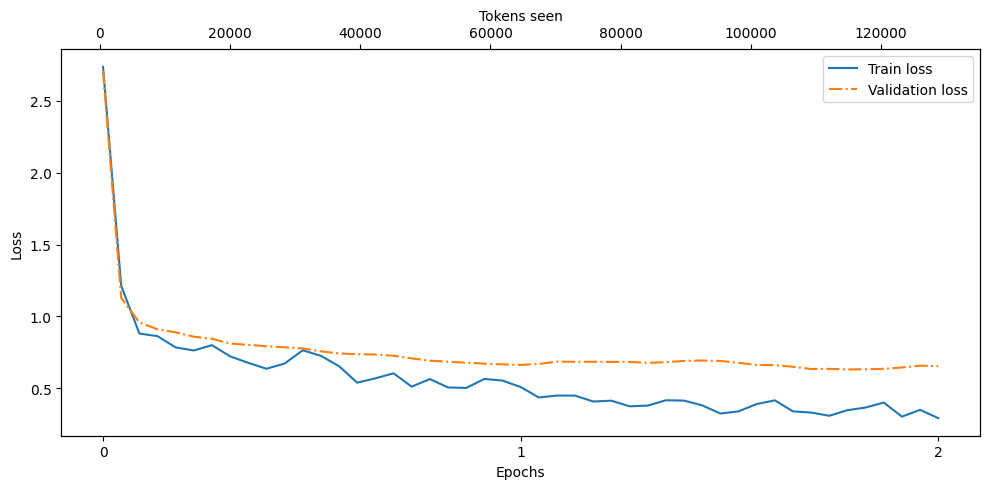

In [20]:
from Chapter5.plot_utils import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))

plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### Extracting and saving responses

While the loss curve gives us some confidence that the fine-tuned model has improved compared to the pre-trained model, we need to look at the response quality to udnerstand how well it performs. In order to do that we will evaluate our model on the hold-out test set.

First, we extract the responses for the test samples using our model and then we can evaluate them manually. 

In [21]:
torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = (
        generated_text[len(input_text):]
        .replace("\n\n### Response:\n", "")
        .strip()
    )
    print(f"Input:\n{input_text}\n")
    print(f"Correct Response:\n{entry['output']}\n")
    print(f"Generated Response:\n{response_text}\n")
    print("-" * 100)

Input:
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instructions:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct Response:
The car is as fast as lightning.

Generated Response:
The car is as fast as a bullet.

----------------------------------------------------------------------------------------------------
Input:
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instructions:
What type of cloud is typically associated with thunderstorms?

Correct Response:
The type of cloud typically associated with thunderstorms is cumulonimbus.

Generated Response:
A thunderstorm is a type of cloud that typically forms when thunderstorms are strong and can reach altitudes of more than 15,000 feet.

----------------------------------------------------------------------------------------------------
Input:
Below is an instruction that describ

From the responses we see that 2/3 are correct. The second one is not answered correctly. The first response also indicates the difficulty of evaluating the responses in an automated way. The generated response does not match the one given as correct response but it is nevertheless a valid one. In practice such models are evaluated in different ways:

- show-answer and multiple choice benchmarks which test general knowledge of a model
- human preference comparison between multiple LLMs
- automated conversational benchmarks where other LLMs are used to score the responses

In order to evaluate our model here, we will implement a method which uses another LLM to score the responses. We will run the LLM locally through ollama.

We start off by generating all responses from the test set and saving them to file.

In [22]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("\n\n### Response:\n", "")
        .strip()
    )
    test_data[i]["model_response"] = response_text

with open("instruction-data-with-responses.json", "w") as f:
    json.dump(test_data, f, indent=4)

print(test_data[0])        

100%|██████████| 110/110 [06:24<00:00,  3.49s/it]

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


Finally, we will save the fine-tuned model weights to file.

In [ ]:
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL)}-sft.pth"
torch.save(model.state_dict(), file_name)

print(f"Model saved to {file_name}")

Model saved to gpt2-medium355M-sft.pth


### Evaluating the fine-tuned LLM

As mentioned earlier, we will use ollama to evaluate the test responses. In order to do this we need to download ollama itself and the model we want to use - Llama3 in our case.

Once ollama is installed, we can start the application using `ollama serve` and pull the model through the command `ollama pull llama3`. To test that we can load and run the model, we can start an interactive ollama chat session through `ollama run llama3`.

We will also implement a function to verify that we can query the model as expected before we start evaluating our test set.

In [25]:
import psutil


def check_if_running(process_name: str) -> bool:
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

if not check_if_running("ollama"):
    raise RuntimeError("Ollama is not running")
    
print("Ollama running: ", check_if_running("ollama"))

Ollama running:  True


While the interactive chat session is good for direct access to llama3, we will access the model through ollamas REST API. We will define a function which queries the model and returns the response data.

In [26]:
import urllib.request


def query_model(
    prompt: str,
    model: str = "llama3",
    url: str = "http://localhost:11434/api/chat"
) -> str:
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {
            "seed": 123,
            "temperature": 0.,
            "num_ctx": 2048
        }
    }

    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(url, data=payload, method="POST")
    request.add_header("Content-Type", "application/json")

    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
    return response_data

In [27]:
model = "llama3"
result = query_model("What do Llamas eat?", model=model)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and well-being.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, including plants like willow, alder, and birch.
2. Bark: In some cases, ll

If successful, we can see the response printed above.

Now let's test the approach on the first 3 samples of our test set.

In [28]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}` "
        f"score the model response `{entry['model_response']}` "
        "on a scale from 0 to 100, where 100 is the best score."
    )
    print("\nDataset response:")
    print(">>", entry["output"])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt, model=model))
    print("-" * 100)


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> I'd score my own response a 90 out of 100.

Here's why:

* The original instruction asks for a simile, which is a figure of speech that compares two unlike things using "like" or "as."
* My response, "The car is as fast as a bullet," meets this requirement by comparing the car's speed to something else (a bullet) using "as."
* The comparison is also relevant and evocative, conveying the idea that the car is extremely quick.
* However, I could have done better by choosing a more unexpected or creative comparison, like "The car is as fast as a cheetah" or "The car is as fast as a speeding comet." These comparisons might have added more surprise and interest to the sentence.

Overall, while my response is good, it's not exceptional. I'd give myself 90 out of 100 for this one!
--------------------------------------------------------------------------------------------------

We can see that llama3 provides a reasonable evaluation of each response, scoring the wrong answer to question 2 low.

In order to use the returned score we want a less elaborate output from Llama 3 though. We will do this by updating the prompt to Llama 3, asking it to only output the number.

In [29]:
def generate_model_scores(json_data: list[dict[str, Any]], json_key: str, model: str = "llama3") -> list[dict[str, Any]]:
    scores = []
    for entry in json_data:
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}` "
            f"score the model response `{entry['model_response']}` "
            "on a scale from 0 to 100, where 100 is the best score. "
            "Respond with the integer number only."
        )
        score = query_model(prompt, model=model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score {score}.")
            continue
    return scores

In [30]:
scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores) / len(scores):.2f}\n")

Number of scores: 110 of 110
Average score: 53.04



To further improve the response quality we could:

- Adjust the hyperparameters during fine-tuning such as learning rate, batch size or number of epochs
- Increase the size of the training set and / or diversify the examples
- Adjust the prompts and instruction format to better guide the model
- Use larger pretrained models which can capture more complex patterns

The Llama 3 8B model for example achives an average score of 82.6 using this methodology. We can use LoRA for example to fine-tune a larger model even with limited resources.